In [43]:
import os, sys
import numpy as np
import matplotlib
from matplotlib import animation
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.optim import AdamW

import gym

from utils import seed_everything, plot_stats, display_video

# Utility

In [4]:
def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/var/folders/w_/907_7v250273p09qmhk2l72m0000gn/T/ipykernel_1623/377624470.py:22: SyntaxWarning: invalid escape sequence '\p'
  plt.title("$\pi(s)$", size=16)


# Initialize the environment

In [6]:
env = gym.make("CartPole-v1")

In [7]:
dims = env.observation_space.shape[0]
actions = env.action_space.n
print(f"State dimentions: {dims}, Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimentions: 4, Actions: 2
Sample state: [-0.03684902 -0.02833617 -0.01210653 -0.01472904]


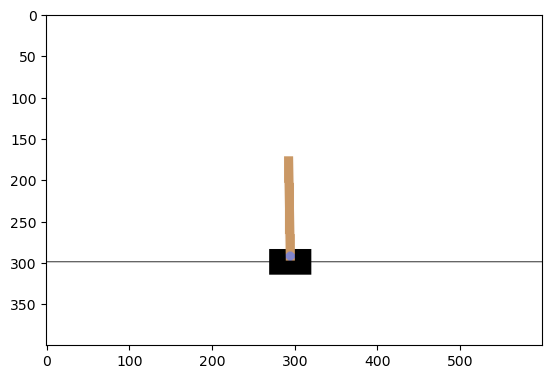

In [8]:
plt.imshow(env.render(mode="rgb_array"))

# Prepare the environment to work with PyTorch

In [9]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()

    def step(self, actions):
        actions = actions.squeeze().numpy()
        next_state, reward, done, info = self.env.step(actions)
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [12]:
num_envs = os.cpu_count()
parallel_env = gym.vector.make('CartPole-v1', num_envs=num_envs)
seed_everything(parallel_env)
parallel_env = PreprocessEnv(parallel_env)

In [15]:
parallel_env.reset()

tensor([[-0.0406,  0.0476,  0.0261,  0.0286],
        [ 0.0087, -0.0275,  0.0252, -0.0236],
        [-0.0338,  0.0357, -0.0337, -0.0162],
        [ 0.0010,  0.0279,  0.0296,  0.0095],
        [ 0.0434, -0.0415,  0.0129,  0.0276],
        [ 0.0467, -0.0179, -0.0300,  0.0358],
        [ 0.0152,  0.0363,  0.0090,  0.0028],
        [ 0.0156, -0.0486,  0.0276,  0.0496],
        [-0.0263,  0.0147, -0.0435,  0.0056],
        [ 0.0286, -0.0283,  0.0306,  0.0233]])

# Create the policy  𝜋(𝑠)

In [16]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1))

# Plot action probabilities

In [31]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

In [32]:
neutral_state

tensor([0., 0., 0., 0.])

### Plot a neutral environment

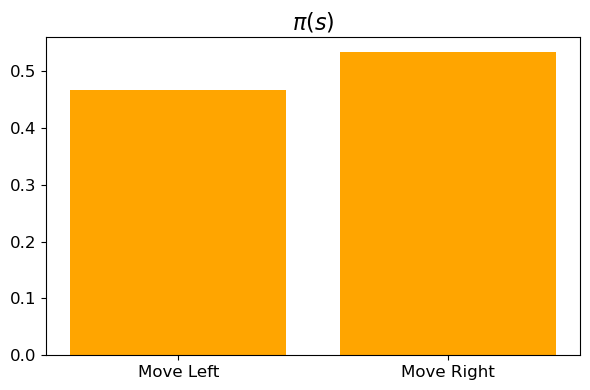

In [33]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

### Plot a state where the cart is too far left

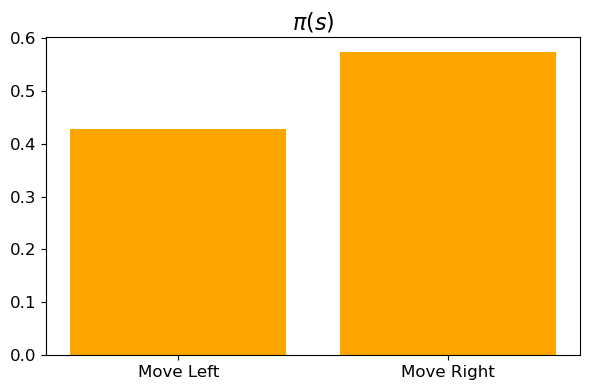

In [34]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

### Plot a state where the cart is too far right

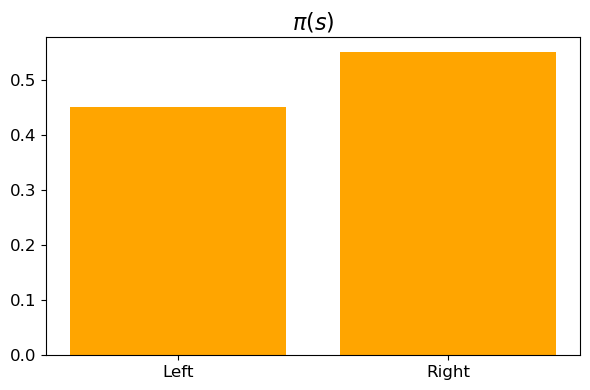

In [35]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

# Implement the algorithm

In [36]:
def reinforce(policy, episodes, alpha=1e-4, gamma=0.99):
    optim = AdamW(policy.parameters(), lr=alpha)
    stats = {'PG Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        transitions = []
        ep_return = torch.zeros((num_envs, 1))

        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b * reward])
            ep_return += reward
            done_b |= done
            state = next_state

        G = torch.zeros((num_envs, 1))
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)

            entropy_t = - torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma ** t
            pg_loss_t = - gamma_t * action_log_prob_t * G
            total_loss_t = (pg_loss_t - 0.01 * entropy_t).mean()

            policy.zero_grad()
            total_loss_t.backward()
            optim.step()

        stats['PG Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats

In [37]:
stats = reinforce(policy, 200)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.91it/s]


# Show results

### Show execution stats

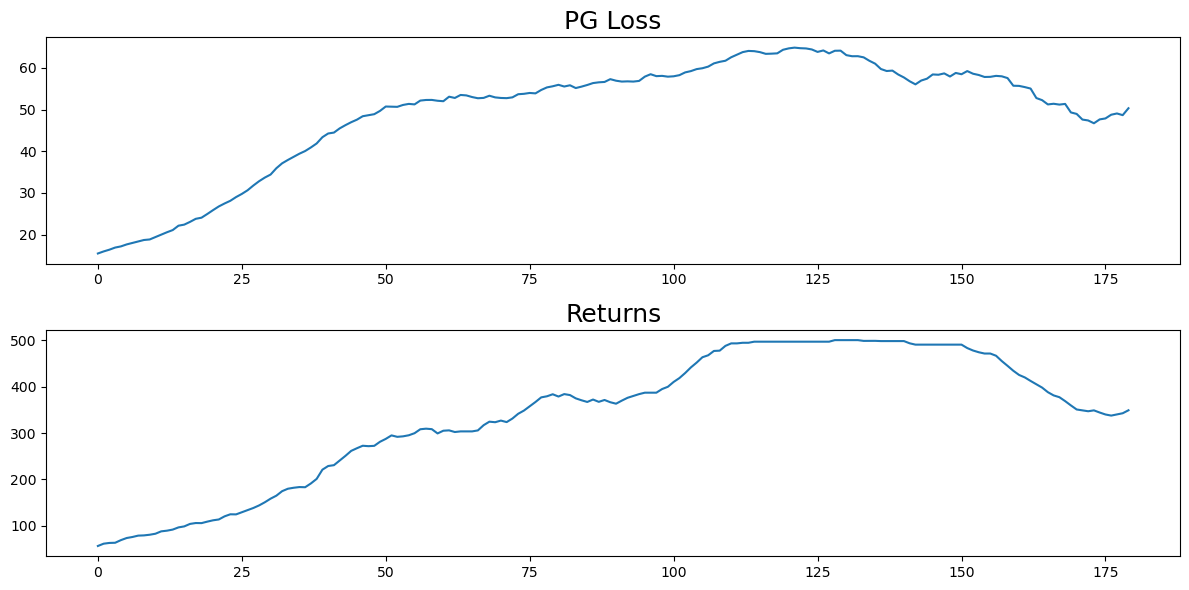

In [38]:
plot_stats(stats)

### Show resulting policy

In [ ]:
plot_policy(action_values, frame)

### Plot action probabilities

#### Plot a neutral environment

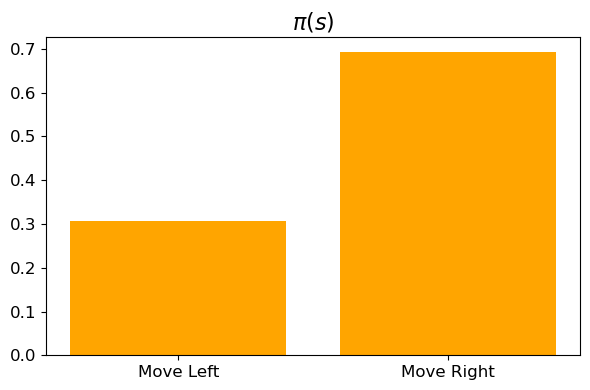

In [39]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

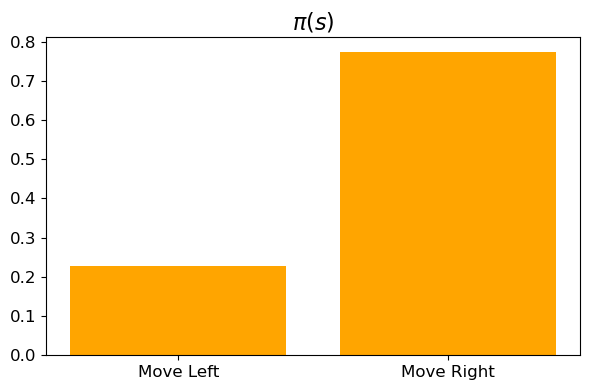

In [40]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

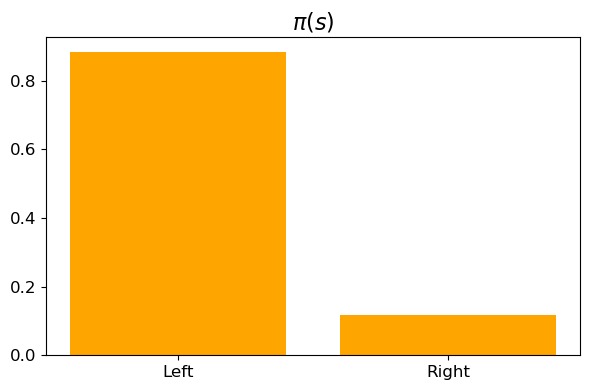

In [41]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

In [44]:
test_policy_network(env, policy, episodes=5)

In [45]:
p1 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
e1 = - np.sum(p1 * np.log(p1))
p1, e1

(array([0.2, 0.2, 0.2, 0.2, 0.2]), 1.6094379124341005)

In [47]:
p2 = np.array([1.0, 1e-6, 1e-6, 1e-6, 1e-6,])
e2 = - np.sum(p2 * np.log(p2))
p2, e2

(array([1.e+00, 1.e-06, 1.e-06, 1.e-06, 1.e-06]), 5.526204223185709e-05)

In [ ]:
# REINFORCE 알고리즘의 기본 구조

def REINFORCE(environment, policy_network, num_episodes, learning_rate):
    # 정책 네트워크 초기화
    policy = policy_network
    optimizer = create_optimizer(policy.parameters(), learning_rate)

    # 에피소드 반복
    for episode in range(num_episodes):
        # 환경 초기화
        state = environment.reset()
        trajectory = []

        # 한 에피소드 진행
        while not environment.is_done():
            # 정책 네트워크로 행동 선택
            action = policy.select_action(state)
            
            # 환경에서 다음 상태, 보상, 종료 여부 얻기
            next_state, reward, done = environment.step(action)
            
            # 궤적에 저장 (상태, 행동, 보상)
            trajectory.append((state, action, reward))
            
            state = next_state

        # 에피소드 종료 후 보상 계산
        total_return = calculate_returns(trajectory)

        # 정책 그라디언트 계산 및 업데이트
        policy_loss = calculate_policy_loss(policy, trajectory, total_return)
        
        # 옵티마이저로 네트워크 파라미터 업데이트
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

def calculate_returns(trajectory):
    # 할인된 누적 보상 계산
    returns = []
    G = 0
    for _, _, reward in reversed(trajectory):
        G = reward + gamma * G  # gamma는 할인 계수
        returns.insert(0, G)
    return returns

def calculate_policy_loss(policy, trajectory, returns):
    policy_loss = 0
    for (state, action, _), G in zip(trajectory, returns):
        # 로그 정책 확률 계산
        log_prob = policy.log_prob(state, action)
        
        # 정책 그라디언트 loss 계산
        policy_loss -= log_prob * G

    return policy_loss